# DCNN Keras Image Classifier

- Author: Felipe Silveira (felipesilveira@ieee.org)
- A simple and generic image classifier built with Keras using cuda libraries.
- [Base code](https://github.com/gabrielkirsten/cnn_keras)

In [ ]:
!pip install matplotlib
!pip install scikit-learn
!pip install Pillow

In [1]:
import time
import os
import argparse
import itertools
import matplotlib.pyplot as plt
import numpy as np
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import metrics

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings
START_TIME = time.time()

In [4]:
DATA_DIR = "../data/1440/5X/original"
TRAIN_DATA_DIR = "../data/1440/5X/train"
VALIDATION_DATA_DIR = "../data/1440/5X/validation"

In [5]:
CLASS_NAMES = os.listdir(DATA_DIR)
CLASS_NAMES = [x.title() for x in CLASS_NAMES]
CLASS_NAMES = [x.replace('_',' ') for x in CLASS_NAMES]

In [6]:
CLASS_NAMES

['Euphorbia Pulcherrima',
 'Leucaena Leucocephala',
 'Hidrocleys Nymphoides',
 'Azadirachta Indica',
 'Banisteria Argyrophylla',
 'Camptostema Ellipticum',
 'Matayba Guianensis',
 'Inga Vera',
 'Casearia Aculeata',
 'Bauhinia',
 'Simarouba Versicolor',
 'Bixa Orellana',
 'Mitostemma Brevifilis',
 'Moringa Oleifera',
 'Handroanthus Heptaphyllus',
 'Plinia Cauliflora',
 'Cocos Nucifera']

In [7]:
IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 1e-3

In [8]:
def plot_confusion_matrix(confusion_matrix_to_print, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
        This function prints applicationsand plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(confusion_matrix_to_print, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = confusion_matrix_to_print.max() / 2.
    for i, j in itertools.product(range(confusion_matrix_to_print.shape[0]),
                                  range(confusion_matrix_to_print.shape[1])):
        plt.text(j, i, format(confusion_matrix_to_print[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_to_print[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
def make_confusion_matrix_and_plot(validation_generator, file_name, model_final):
    """Predict and plot confusion matrix"""

    validation_features = model_final.predict_generator(validation_generator,
                                                        validation_generator.samples,
                                                        verbose=1)

    plt.figure(figsize=(12,12))

    plot_confusion_matrix(confusion_matrix(np.argmax(validation_features, axis=1),
                                           validation_generator.classes),
                          classes=CLASS_NAMES,
                          title='Confusion Matrix Graph')

    plt.savefig('../output_images/' + file_name + '_matrix.png')

    print("Total time after generate confusion matrix: %s" %
          (time.time() - START_TIME))

In [10]:
def plot_training_history(history, file_name):
    '''
    Generate loss & accuracy plots for training & validation
    '''
    
    plt.figure(figsize=(6,4))
    
    plt.ylabel('Accuracy & Loss')
    plt.xlabel('Epoch')
    plt.title('Accuracy & Loss Learning Curve Graph')
    plt.legend(['Train', 'Val'], loc='upper left')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label="Training accuracy")
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy")    
    plt.plot(history.history['val_loss'], label="Validation loss")
    
    plt.savefig('../output_images/' + file_name + '_history.png')

In [11]:
def main(arch, ftuning):
    """
        arch->architecture: Xception, VGG16, VGG19, ResNet50, InceptionV3, MobileNet
        ftuning->fine tuning rate: i.e. 0 25 50 75 -1--without imagenet weights--
    """


    if ftuning != -1:
        if arch == "Xception":
            model = applications.Xception(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "VGG16":
            model = applications.VGG16(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "VGG19":
            model = applications.VGG19(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "ResNet50":
            model = applications.ResNet50(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "InceptionV3":
            model = applications.InceptionV3(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "MobileNet":
            model = applications.MobileNet(
                weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

    # calculate how much layers won't be retrained according on fineTuningRate parameter
        n_layers = len(model.layers)
        last_layers = n_layers - int(n_layers * (ftuning / 100.))
        for layer in model.layers[:last_layers]:
            layer.trainable = False

    else:  # without transfer learning
        if arch == "Xception":
            model = applications.Xception(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "VGG16":
            model = applications.VGG16(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "VGG19":
            model = applications.VGG19(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "ResNet50":
            model = applications.ResNet50(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "InceptionV3":
            model = applications.InceptionV3(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        elif arch == "MobileNet":
            model = applications.MobileNet(
                weights=None, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
        for layer in model.layers:
            layer.trainable = True

    # Initiate the train and test generators with data Augumentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
        fill_mode="nearest",
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rotation_range=30)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="categorical")

    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
        fill_mode="nearest",
        zoom_range=0.3,
        width_shift_range=0.3,
        height_shift_range=0.3,
        rotation_range=30)

    validation_generator = test_datagen.flow_from_directory(
        VALIDATION_DATA_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        class_mode="categorical")

    # Adding custom Layers
    new_custom_layers = model.output
    new_custom_layers = Flatten()(new_custom_layers)
    new_custom_layers = Dense(1024, activation="relu")(new_custom_layers)
    new_custom_layers = Dropout(0.5)(new_custom_layers)
    new_custom_layers = Dense(1024, activation="relu")(new_custom_layers)
    try:
        num_classes = train_generator.num_class
    except:
        num_classes = train_generator.num_classes
    predictions = Dense(num_classes, activation="softmax")(new_custom_layers)

    # creating the final model
    model_final = Model(inputs=model.input, outputs=predictions)

    # compile the model
    model_final.compile(loss="categorical_crossentropy",
                        optimizer=optimizers.SGD(lr=LEARNING_RATE, momentum=0.9),
                        metrics=["accuracy"])

    # select .h5 filename
    if ftuning == 0:
        file_name = arch + \
            '_transfer_learning'
    elif ftuning == -1:
        file_name = arch + \
            '_without_transfer_learning'
    else:
        file_name = arch + \
            '_fine_tunning_' + str(ftuning)

    # Save the model according to the conditions
    checkpoint = ModelCheckpoint("../models_checkpoints/" + file_name + "_model.h5", monitor='val_accuracy',
                                 verbose=1, save_best_only=True, save_weights_only=False,
                                 mode='auto', period=1)
    
    early_stopping = EarlyStopping(verbose=True, patience=15, monitor='val_accuracy')

    # Train the model
    history = model_final.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping,checkpoint],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE)

    print("Total time to train: %s" % (time.time() - START_TIME))
    
    # Saving the model
    #model.save("../models_checkpoints/" + file_name + "_model.h5")  # creates a HDF5 file 'my_model.h5'
    
    # Saving the weights
    model.save_weights("../models_checkpoints/" + file_name + "_weights.h5")
    
    plot_training_history(history, file_name)

    validation_generator = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
        VALIDATION_DATA_DIR,
        batch_size=1,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode="categorical")

    make_confusion_matrix_and_plot(
        validation_generator, file_name, model_final)
    
    # Validation predict
    validation_predict = model_final.predict_generator(validation_generator, steps=None)
    
    # Printing sklearn metrics report for test
    y_true = validation_generator.classes
    y_pred = np.argmax(validation_predict, axis=1)
    report = metrics.classification_report(y_true, y_pred, digits=6)
    print(report)

Found 204 images belonging to 17 classes.
Found 68 images belonging to 17 classes.
Epoch 1/2
12/12 [==============================] - 9s 789ms/step - loss: 2.9151 - accuracy: 0.0532 - val_loss: 2.8498 - val_accuracy: 0.0938

Epoch 00001: val_accuracy improved from -inf to 0.09375, saving model to ../models_checkpoints/Xception_transfer_learning_model.h5
Epoch 2/2
12/12 [==============================] - 6s 465ms/step - loss: 2.8671 - accuracy: 0.1277 - val_loss: 2.7967 - val_accuracy: 0.1923

Epoch 00002: val_accuracy improved from 0.09375 to 0.19231, saving model to ../models_checkpoints/Xception_transfer_learning_model.h5
Total time to train: 25.17099404335022
Found 68 images belonging to 17 classes.
68/68 [==============================] - 4s 55ms/step
Total time after generate confusion matrix: 30.718579053878784
              precision    recall  f1-score   support

           0   0.000000  0.000000  0.000000         4
           1   0.000000  0.000000  0.000000         4
        

/home/silveira/anaconda3/envs/pollen-zoom/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


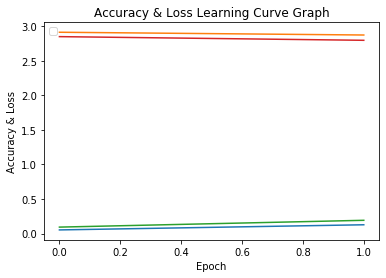

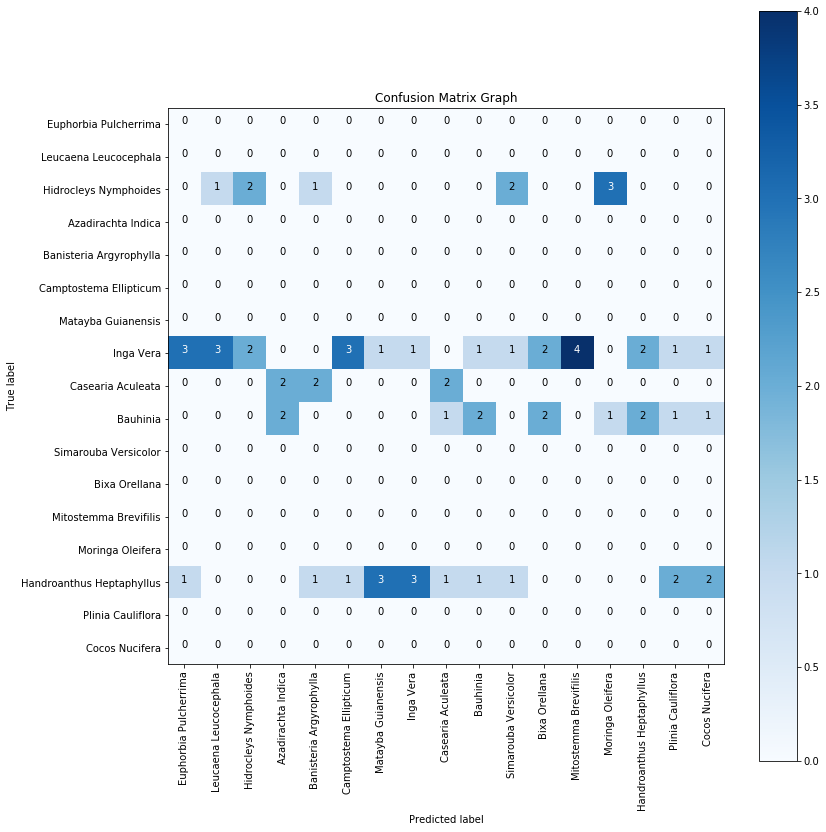

In [12]:
main("Xception", 0)